<a href="https://colab.research.google.com/github/faranakGeo/skills-introduction-to-github/blob/main/PINNEikonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Objective.** Solve the 2D eikonal equation for first‑arrival traveltime \(T(x,z)\) with a vertically varying velocity \(v(z)\) using a **Physics‑Informed Neural Network (PINN)** and the **factored** form


In [2]:
pip install scikit-fmm

In [3]:

import math, random, time
import numpy as np
import torch
from torch import nn
from torch.autograd import grad
import matplotlib.pyplot as plt

# Optional: Fast Marching
try:
    import skfmm
    HAS_SKFMM = True
except Exception as e:
    print("scikit-fmm not found. To enable Fast Marching comparison, install with:")
    print("  pip install scikit-fmm")
    HAS_SKFMM = False

# Reproducibility
seed = 101
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

## Domain & Velocity

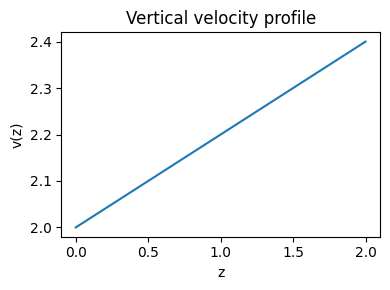

In [4]:

# Domain (km for intuition)
Lx, Lz = 2.0, 2.0
xs, zs = 1.0, 0.6

# Vertical linear gradient: v(z) = v0 + g z
v0, g = 2.0, 0.2

def velocity(z):
    return v0 + g*z


# Visualize v(z)
zsamp = np.linspace(0, Lz, 200)
plt.figure(figsize=(4,3))
plt.plot(zsamp, velocity(zsamp))
plt.xlabel('z'); plt.ylabel('v(z)'); plt.title('Vertical velocity profile')
plt.tight_layout(); plt.show()


## PINN for $\tau(x,z)$ with **positive** output (sigmoid × scale)

In [5]:

class TauPINN(nn.Module):
    def __init__(self, in_dim=2, hidden=[64,64,64], act=nn.Tanh, scale=10.0, eps=0.0):
        super().__init__()
        self.scale = scale
        self.eps = eps
        layers = []
        d = in_dim
        for h in hidden:
            layers += [nn.Linear(d, h), act()]
            d = h
        layers += [nn.Linear(d, 1)]  # raw u
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x):
        u = self.net(x)
        tau = self.eps + torch.sigmoid(u) * self.scale  # > 0
        return tau

pinn = TauPINN(scale=10.0, eps=0.0).to(device)
pinn


TauPINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

## Collocation & Source Sampling

In [6]:

def sample_points(n_interior=5000, n_source=600, r_eps=0.05):
    xin = np.random.rand(n_interior, 1)*Lx
    zin = np.random.rand(n_interior, 1)*Lz
    X_interior = np.hstack([xin, zin]).astype(np.float32)

    angles = 2*np.pi*np.random.rand(n_source, 1)
    radii  = r_eps*np.sqrt(np.random.rand(n_source, 1))
    xs_near = xs + radii*np.cos(angles)
    zs_near = zs + radii*np.sin(angles)
    X_source = np.hstack([xs_near, zs_near]).astype(np.float32)
    return X_interior, X_source

Xin, Xsrc = sample_points()
Xin.shape, Xsrc.shape


((5000, 2), (600, 2))

## Loss: PDE Residual + Source Anchor

In [13]:

def pinn_loss(pinn, x_interior, x_source, lam_src=10.0):
    x_interior = torch.from_numpy(x_interior).to(device); x_interior.requires_grad_(True)
    x_source   = torch.from_numpy(x_source).to(device);   x_source.requires_grad_(True)

    # Interior residual
    x = x_interior[:, :1]; z = x_interior[:, 1:2]
    r = torch.sqrt((x - xs)**2 + (z - zs)**2 + 1e-8)
    tau = pinn(torch.cat([x, z], dim=1))
    T = r * tau
    dTdx = grad(T, x_interior, torch.ones_like(T), create_graph=True)[0][:, :1]
    dTdz = grad(T, x_interior, torch.ones_like(T), create_graph=True)[0][:, 1:2]
    gradT = torch.sqrt(dTdx**2 + dTdz**2 + 1e-12)
    loss_pde = torch.mean( (gradT - 1.0/velocity(z))**2 )

    # Source anchor: tau(xs,zs) ≈ 1/v(zs)
    xs_t = x_source[:, :1]; zs_t = x_source[:, 1:2]
    tau_src = pinn(torch.cat([xs_t, zs_t], dim=1))
    v_zs = velocity(torch.tensor([zs], dtype=torch.float32).to(device))
    loss_src = torch.mean( (tau_src - 1.0/v_zs)**2 )
    return loss_pde, loss_src


## Train

In [8]:

def train(pinn, epochs=15000, lr=2e-3, lam_src=10.0, print_every=100):
    opt = torch.optim.Adam(pinn.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[900, 1100], gamma=0.3)
    Xin, Xsrc = sample_points()
    hist = {'pde': [], 'src': [], 'total': []}
    for ep in range(1, epochs+1):
        opt.zero_grad()
        lpde, lsrc = pinn_loss(pinn, Xin, Xsrc, lam_src=lam_src)
        loss = lpde + lam_src*lsrc
        loss.backward(); opt.step(); sched.step()
        hist['pde'].append(lpde.item()); hist['src'].append(lsrc.item()); hist['total'].append(loss.item())
        if ep % print_every == 0:
            print(f"Epoch {ep:4d} | PDE {lpde.item():.3e} | Src {lsrc.item():.3e} | Total {loss.item():.3e}")
        if ep % 50 == 0:
            Xin, Xsrc = sample_points()
    return hist

hist = train(pinn, epochs=15000, lr=2e-3, lam_src=10.0)


Epoch  100 | PDE 3.888e-01 | Src 1.908e-01 | Total 2.297e+00
Epoch  200 | PDE 3.313e-01 | Src 1.205e-01 | Total 1.536e+00
Epoch  300 | PDE 1.091e-01 | Src 2.274e-04 | Total 1.114e-01
Epoch  400 | PDE 1.276e-02 | Src 3.039e-05 | Total 1.306e-02
Epoch  500 | PDE 8.231e-03 | Src 4.528e-05 | Total 8.684e-03
Epoch  600 | PDE 6.639e-03 | Src 3.732e-05 | Total 7.012e-03
Epoch  700 | PDE 5.278e-03 | Src 2.735e-05 | Total 5.551e-03
Epoch  800 | PDE 3.975e-03 | Src 1.996e-05 | Total 4.175e-03
Epoch  900 | PDE 3.024e-03 | Src 1.480e-05 | Total 3.172e-03
Epoch 1000 | PDE 2.690e-03 | Src 1.302e-05 | Total 2.820e-03
Epoch 1100 | PDE 2.395e-03 | Src 1.157e-05 | Total 2.510e-03
Epoch 1200 | PDE 2.291e-03 | Src 1.113e-05 | Total 2.402e-03
Epoch 1300 | PDE 2.338e-03 | Src 1.097e-05 | Total 2.448e-03
Epoch 1400 | PDE 2.174e-03 | Src 9.777e-06 | Total 2.271e-03
Epoch 1500 | PDE 2.051e-03 | Src 9.668e-06 | Total 2.148e-03
Epoch 1600 | PDE 2.090e-03 | Src 9.616e-06 | Total 2.186e-03
Epoch 1700 | PDE 2.004e-

## Training Curves

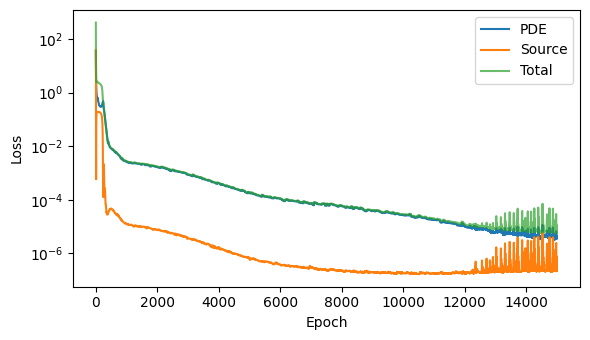

In [9]:

plt.figure(figsize=(6,3.5))
plt.plot(hist['pde'], label='PDE')
plt.plot(hist['src'], label='Source')
plt.plot(hist['total'], label='Total', alpha=0.7)
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()


## Evaluate on Grid + Analytical + Fast Marching

In [10]:

def evaluate_grid(pinn, nx=181, nz=181):
    xs_lin = np.linspace(0, Lx, nx); zs_lin = np.linspace(0, Lz, nz)
    XX, ZZ = np.meshgrid(xs_lin, zs_lin)  # (nz, nx) with ZZ increasing downward
    with torch.no_grad():
        inp = torch.from_numpy(np.stack([XX.ravel(), ZZ.ravel()], axis=1).astype(np.float32)).to(device)
        tau = pinn(inp).cpu().numpy().reshape(nz, nx)
    R = np.sqrt((XX - xs)**2 + (ZZ - zs)**2) + 1e-8
    T = R * tau
    return XX, ZZ, T, tau

XX, ZZ, T_pinn, tau = evaluate_grid(pinn)

# Analytical T_data (user formula)
velmodel = velocity(ZZ)  # v(z) on grid
vs = velocity(zs)        # v at source
num = 1.0 + 0.5*(1.0/velmodel)*(1.0/vs)*(g**2)*((XX - xs)**2 + (ZZ - zs)**2)
den = np.sqrt(g**2 + 1e-12)  # avoid 0/0
T_data = np.arccosh(num) / den

# Fast Marching (if available)
if HAS_SKFMM:
    nz, nx = ZZ.shape
    x = np.linspace(0, Lx, nx)
    z = np.linspace(0, Lz, nz)
    # speed field = v(z)
    speed = velmodel.copy()
    # source mask: -1 at source grid node, +1 elsewhere
    ix = np.argmin(np.abs(x - xs))
    iz = np.argmin(np.abs(z - zs))
    phi = np.ones_like(speed)
    phi[iz, ix] = -1.0
    dx = (z[1] - z[0], x[1] - x[0])  # (dz, dx) matches array order [z, x]
    T_fmm = skfmm.travel_time(phi, speed, dx=dx,order=1)
else:
    T_fmm = None

# Basic stats
print("PINN T min/max:", float(T_pinn.min()), float(T_pinn.max()))
print("Analytic T min/max:", float(T_data.min()), float(T_data.max()))
if T_fmm is not None:
    print("FMM   T min/max:", float(T_fmm.min()), float(T_fmm.max()))

# Errors vs analytical
abs_err_pinn = np.abs(T_pinn - T_data)
rel_err_pinn = abs_err_pinn / np.maximum(np.abs(T_data), 1e-6)
mae_pinn  = float(np.mean(abs_err_pinn))
rmse_pinn = float(np.sqrt(np.mean((T_pinn - T_data)**2)))
mre_pinn  = float(np.mean(rel_err_pinn))
print(f"PINN vs Analytical — MAE: {mae_pinn:.4f} | RMSE: {rmse_pinn:.4f} | Mean Rel Err: {mre_pinn:.4f}")

if T_fmm is not None:
    abs_err_fmm = np.abs(T_fmm - T_data)
    rel_err_fmm = abs_err_fmm / np.maximum(np.abs(T_data), 1e-6)
    mae_fmm  = float(np.mean(abs_err_fmm))
    rmse_fmm = float(np.sqrt(np.mean((T_fmm - T_data)**2)))
    mre_fmm  = float(np.mean(rel_err_fmm))
    print(f"FMM  vs Analytical — MAE: {mae_fmm:.4f} | RMSE: {rmse_fmm:.4f} | Mean Rel Err: {mre_fmm:.4f}")


PINN T min/max: 4.7204804420471195e-09 0.7641451233199446
Analytic T min/max: 0.0 0.7619949741905065
FMM   T min/max: 0.0018530051917886466 0.7665526959641026
PINN vs Analytical — MAE: 0.0007 | RMSE: 0.0009 | Mean Rel Err: 0.0019
FMM  vs Analytical — MAE: 0.0024 | RMSE: 0.0028 | Mean Rel Err: 0.0639


## Plots

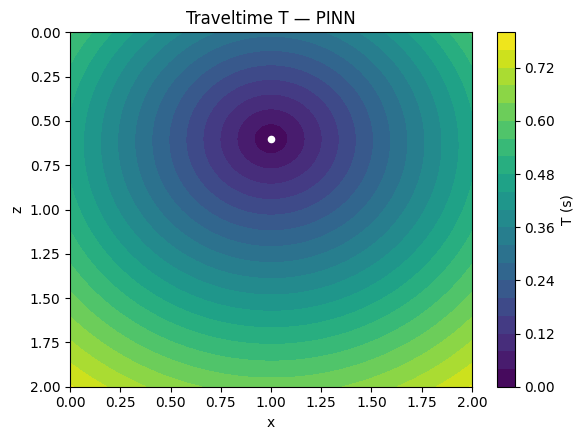

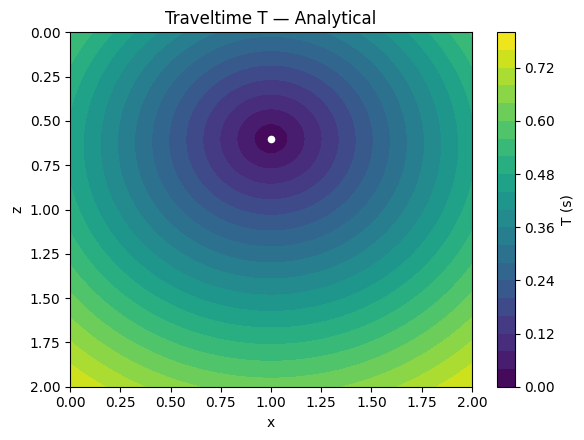

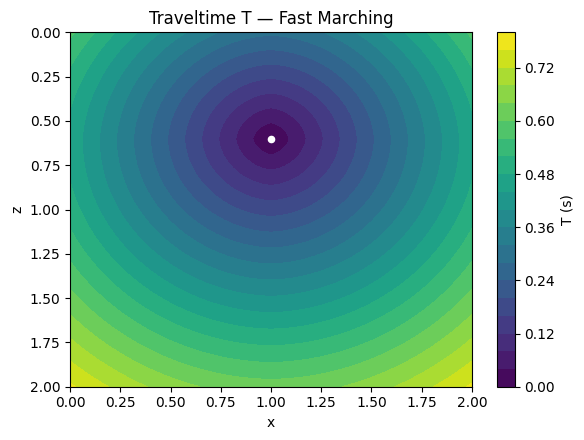

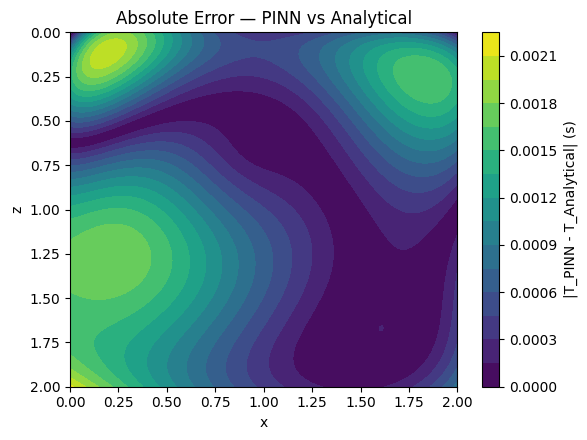

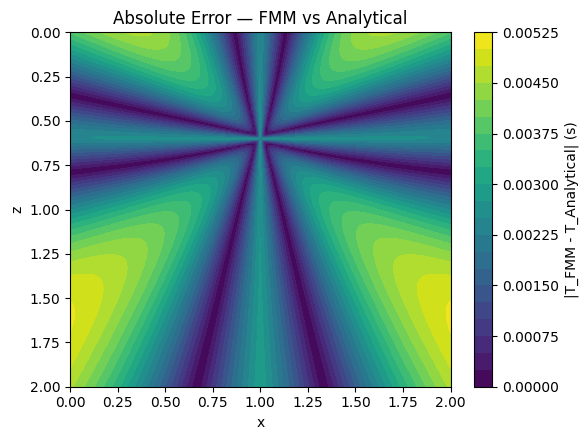

In [11]:

# PINN
plt.figure(figsize=(6,4.5))
cs = plt.contourf(XX, ZZ, T_pinn, levels=20)
plt.gca().invert_yaxis()
plt.colorbar(cs, label='T (s)')
plt.scatter([xs],[zs], c='w', s=20)
plt.xlabel('x'); plt.ylabel('z'); plt.title('Traveltime T — PINN')
plt.tight_layout(); plt.show()

# Analytical
plt.figure(figsize=(6,4.5))
cs = plt.contourf(XX, ZZ, T_data, levels=20)
plt.gca().invert_yaxis()
plt.colorbar(cs, label='T (s)')
plt.scatter([xs],[zs], c='w', s=20)
plt.xlabel('x'); plt.ylabel('z'); plt.title('Traveltime T — Analytical')
plt.tight_layout(); plt.show()

# FMM (if available)
if 'T_fmm' in globals() and T_fmm is not None:
    plt.figure(figsize=(6,4.5))
    cs = plt.contourf(XX, ZZ, T_fmm, levels=20)
    plt.gca().invert_yaxis()
    plt.colorbar(cs, label='T (s)')
    plt.scatter([xs],[zs], c='w', s=20)
    plt.xlabel('x'); plt.ylabel('z'); plt.title('Traveltime T — Fast Marching')
    plt.tight_layout(); plt.show()

# Error maps (PINN vs Analytical)
plt.figure(figsize=(6,4.5))
cs = plt.contourf(XX, ZZ, np.abs(T_pinn - T_data), levels=20)
plt.gca().invert_yaxis()
plt.colorbar(cs, label='|T_PINN - T_Analytical| (s)')
plt.xlabel('x'); plt.ylabel('z'); plt.title('Absolute Error — PINN vs Analytical')
plt.tight_layout(); plt.show()



# Error maps (FMM vs Analytical) if available
if 'T_fmm' in globals() and T_fmm is not None:
    plt.figure(figsize=(6,4.5))
    cs = plt.contourf(XX, ZZ, np.abs(T_fmm - T_data), levels=20)
    plt.gca().invert_yaxis()
    plt.colorbar(cs, label='|T_FMM - T_Analytical| (s)')
    plt.xlabel('x'); plt.ylabel('z'); plt.title('Absolute Error — FMM vs Analytical')
    plt.tight_layout(); plt.show()



#Practice Prompts

1. How does the number of collocation points control the acccuracy of PINN solution?
2. What is the impact of the number of epochs on PINN accuracy?
3. What is the impact of the architecture size on PINN accuracy?
4. Change the learning rate and observe the change in the PINN eikonal solution
5. Try changing to a second-order optimizer and observe how convergence changes
